# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load liver raw dataset

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/ys/data/Liver_data_YS_paper_singlets_raw_20200429.h5ad')

In [5]:
adata.shape

(50856, 25756)

In [6]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [7]:
adata.raw = adata

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC1                  217
DC2                 2186
Early Erythroid     1559
Endothelium         2408
Erythroid           9332
Fibroblast          3356
HSC/MPP             3332
Hepatocyte          8197
Kupffer            12830
MEMP                1768
Mast cell            465
Megakaryocyte       1439
Monocyte             912
NK cell              832
Neut_Myeloid         622
Pre B cell           231
Pre pro B cell       511
Pro B cell           461
pDC precursor        198
dtype: int64

In [9]:
adata.shape

(50856, 25756)

# Subset out hybrids according to new metadata

In [10]:
adata.obs["cell.labels_old"] = adata.obs["cell.labels"]

In [11]:
# read in annotation.csv which contains: 'Cluster' column for leiden clusters and 'Category' column for annotations
annotation = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/ys/resources_for_pipelines/ys_liver_singlet_metadata_20200430.csv", index_col=0)

In [12]:
annotation[:5]

,cell.labels
index,
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT,HSC/MPP
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC,Kupffer cell 1
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC,Kupffer cell 2
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG,Hepatocyte
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCACCACGTG,Kupffer cell 1


In [13]:
adata.obs["cell.labels"] = annotation

In [14]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell progenitor          1098
DC1                         183
DC2                        1586
Early Erythroid            4270
Endothelium                3256
Erythroid                  6485
Fibroblast                 3213
HSC/MPP                    2319
Hepatocyte                 8228
ILC precursor               600
Kupffer cell 1             7965
Kupffer cell 2             3536
Lymphoid progenitor         370
MEMP                       1717
Mast cell                   426
Megakaryocyte              1395
Monocyte                    974
NK                         1111
Neut-myeloid progenitor     550
pDC precursor               203
dtype: int64

In [15]:
celltypes = ['B cell progenitor', 'DC1', 'DC2', 'Early Erythroid', 'Endothelium', 'Erythroid', 'Fibroblast', 
            'HSC/MPP', 'Hepatocyte', 'ILC precursor', 'Kupffer cell 1', 'Kupffer cell 2', 'Lymphoid progenitor', 
            'MEMP', 'Mast cell', 'Megakaryocyte', 'Monocyte', 'NK', 'Neut-myeloid progenitor', 'pDC precursor']

In [16]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [17]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell progenitor          1098
DC1                         183
DC2                        1586
Early Erythroid            4270
Endothelium                3256
Erythroid                  6485
Fibroblast                 3213
HSC/MPP                    2319
Hepatocyte                 8228
ILC precursor               600
Kupffer cell 1             7965
Kupffer cell 2             3536
Lymphoid progenitor         370
MEMP                       1717
Mast cell                   426
Megakaryocyte              1395
Monocyte                    974
NK                         1111
Neut-myeloid progenitor     550
pDC precursor               203
dtype: int64

In [18]:
adata.shape

(49485, 25756)

# Add accompanying colours

In [19]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['B cell progenitor', 'DC1', 'DC2', 'Early Erythroid', 'Endothelium', 'Erythroid', 'Fibroblast', 'HSC/MPP', 'Hepatocyte', 'ILC precursor', 'Kupffer cell 1', 'Kupffer cell 2', 'Lymphoid progenitor', 'MEMP', 'Mast cell', 'Megakaryocyte', 'Monocyte', 'NK', 'Neut-myeloid progenitor', 'pDC precursor'], dtype='object')

In [20]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['B cell progenitor', 'DC1', 'DC2', 
            'Early Erythroid', 'Endothelium', 'Erythroid', 'Fibroblast', 
            'HSC/MPP', 'Hepatocyte', 'ILC precursor', 'Kupffer cell 1', 'Kupffer cell 2', 'Lymphoid progenitor', 
            'MEMP', 'Mast cell', 'Megakaryocyte', 'Monocyte', 'NK', 'Neut-myeloid progenitor', 'pDC precursor'])

In [21]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['B cell progenitor', 'DC1', 'DC2', 'Early Erythroid', 'Endothelium', 'Erythroid', 'Fibroblast', 'HSC/MPP', 'Hepatocyte', 'ILC precursor', 'Kupffer cell 1', 'Kupffer cell 2', 'Lymphoid progenitor', 'MEMP', 'Mast cell', 'Megakaryocyte', 'Monocyte', 'NK', 'Neut-myeloid progenitor', 'pDC precursor'], dtype='object')

In [22]:
adata.obs["cell.labels"].cat.categories[2]

'DC2'

In [23]:
new_colors = np.empty(len(adata.obs["cell.labels"].cat.categories), dtype=object) 

new_colors[[0]] = '#7C7CFF' # B cell progenitor
new_colors[[1]] = '#583D5E' # DC1
new_colors[[2]] = '#6EA85B' # DC2
new_colors[[3]] = '#EA9BC2' # Early Erythroid
new_colors[[4]] = '#EDAD9D' # Endothelium
new_colors[[5]] = '#94BFB1' # Erythroid
new_colors[[6]] = '#B43C52' # Fibroblast
new_colors[[7]] = '#AFBFCC' # HSC/MPP
new_colors[[8]] = '#BD7961' # Hepatocyte
new_colors[[9]] = '#4E1850' # ILC precursor
new_colors[[10]] = '#385B7F' # Kupffer cell 1
new_colors[[11]] = '#4C7BAB' # Kupffer cell 2
new_colors[[12]] = '#E0EE71' # Lymphoid progenitor
new_colors[[13]] = '#814F75' # MEMP
new_colors[[14]] = '#B0A789' # Mast Cell
new_colors[[15]] = '#EE943F' # Megakaryocyte
new_colors[[16]] = '#B49FC8' # Monocyte
new_colors[[17]] = '#73A583' # NK cell
new_colors[[18]] = '#05394A' # Neut_Myeloid Progenitor
new_colors[[19]] = '#686C93' # pDC precursor

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#7C7CFF', '#583D5E', '#6EA85B', '#EA9BC2', '#EDAD9D', '#94BFB1',
       '#B43C52', '#AFBFCC', '#BD7961', '#4E1850', '#385B7F', '#4C7BAB',
       '#E0EE71', '#814F75', '#B0A789', '#EE943F', '#B49FC8', '#73A583',
       '#05394A', '#686C93'], dtype=object)

In [24]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell progenitor          1098
DC1                         183
DC2                        1586
Early Erythroid            4270
Endothelium                3256
Erythroid                  6485
Fibroblast                 3213
HSC/MPP                    2319
Hepatocyte                 8228
ILC precursor               600
Kupffer cell 1             7965
Kupffer cell 2             3536
Lymphoid progenitor         370
MEMP                       1717
Mast cell                   426
Megakaryocyte              1395
Monocyte                    974
NK                         1111
Neut-myeloid progenitor     550
pDC precursor               203
dtype: int64

# Save the raw data

In [25]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [26]:
adata.X

<49485x25756 sparse matrix of type '<class 'numpy.float64'>'
	with 127547149 stored elements in Compressed Sparse Row format>

In [27]:
adata.raw.X

<49485x25756 sparse matrix of type '<class 'numpy.float64'>'
	with 127547149 stored elements in Compressed Sparse Row format>

In [28]:
adata.write('/Users/b8058304/Documents/PhD_work/Coding/ys/data/Liver_data_YS_paper_raw_singlets_20200430.h5ad')

# Pre-process the total dataset

In [29]:
# normalise count data 
sc.pp.normalize_total(adata)

In [30]:
# log the count data 
sc.pp.log1p(adata)

In [31]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [32]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [33]:
# run pca
sc.tl.pca(adata, n_comps=50)

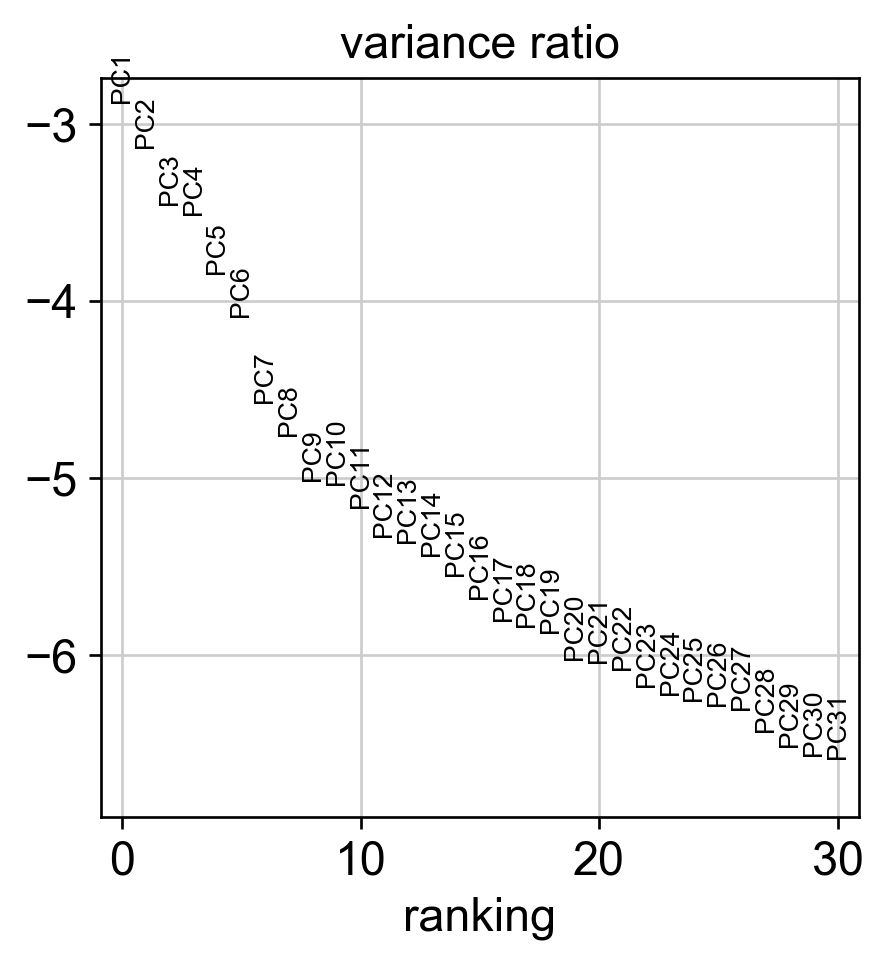

In [34]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [36]:
# run umap
sc.tl.umap(adata) 

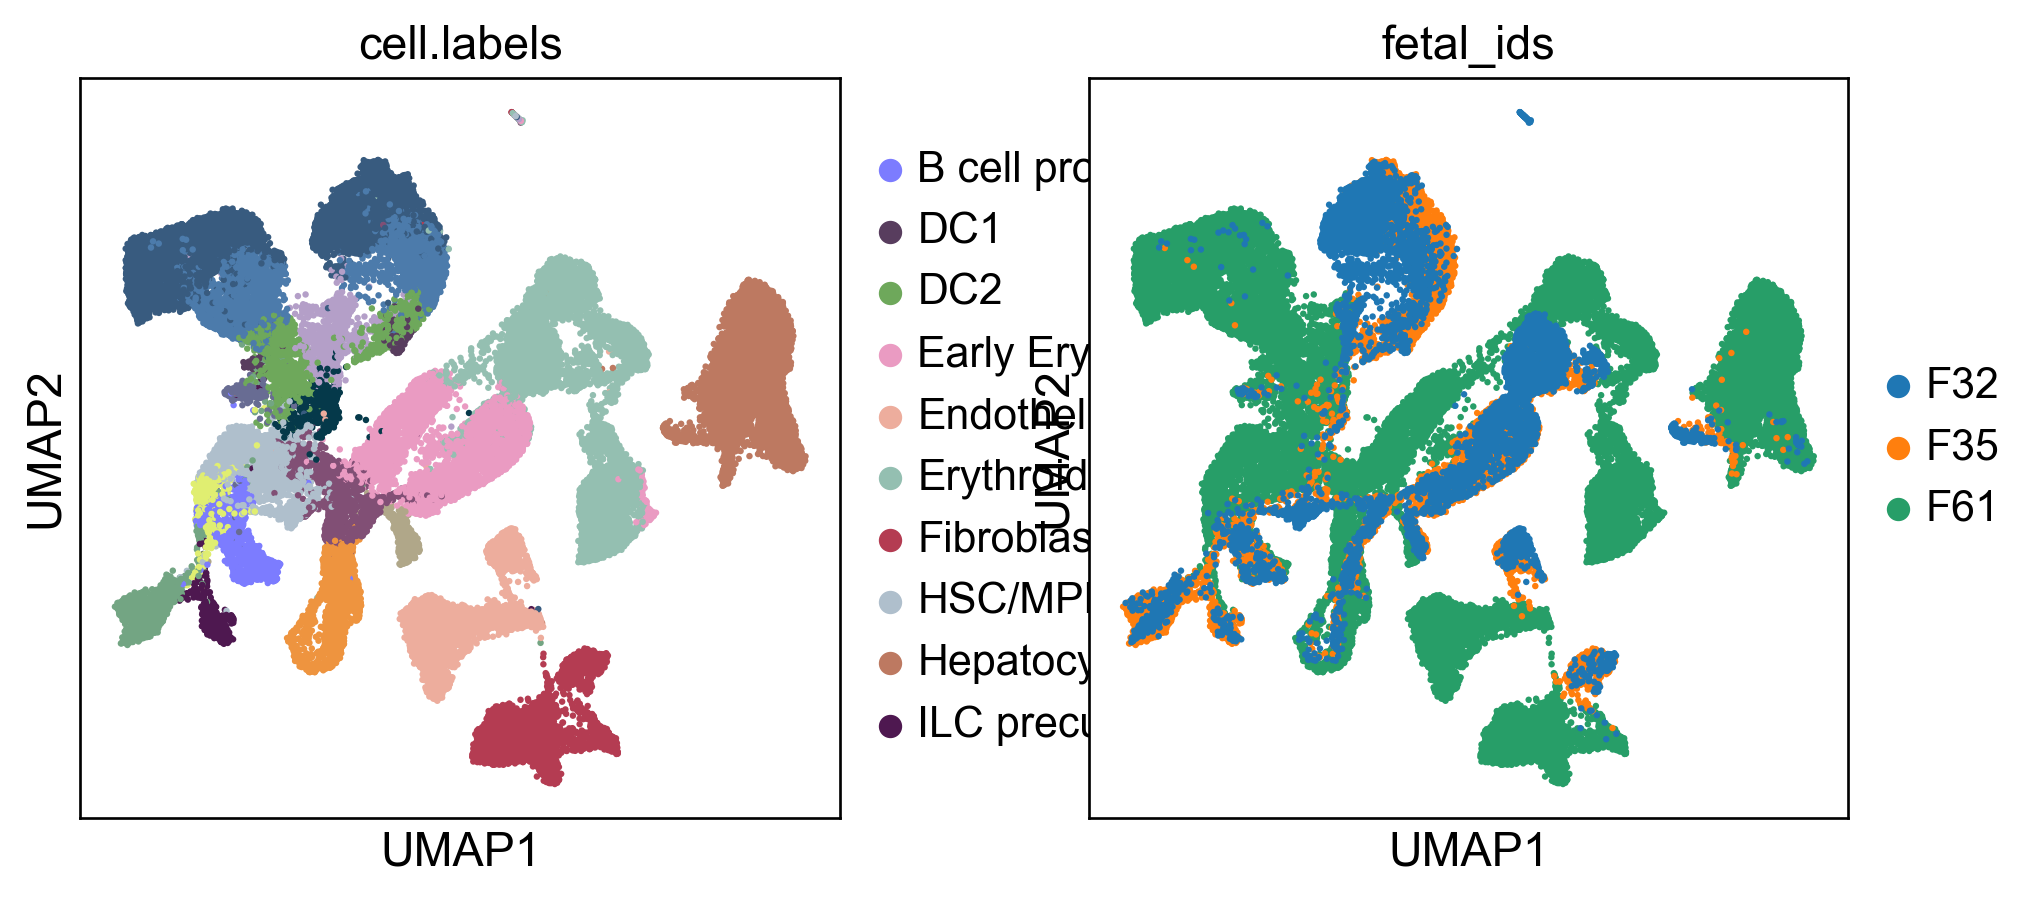

In [37]:
sc.pl.umap(adata, color=['cell.labels', 'fetal_ids'], size=15) 

In [38]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_ys_liver_pre-harmony_20200430_labels_legoff.pdf', show=False, size=2) 
sc.pl.umap(adata, color='cell.labels', save='_ys_liver_pre-harmony_20200430_labels_legon.pdf', show=False, size=2, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='fetal_ids', save='_ys_liver_pre-harmony_20200430_sample_legoff.pdf', show=False, size=2) 
sc.pl.umap(adata, color='fetal_ids', save='_ys_liver_pre-harmony_20200430_sample_legon.pdf', show=False, size=2, legend_loc="on data", legend_fontsize=6)

# Run harmony batch correction

In [39]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['fetal_ids']

In [40]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [41]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [42]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP 

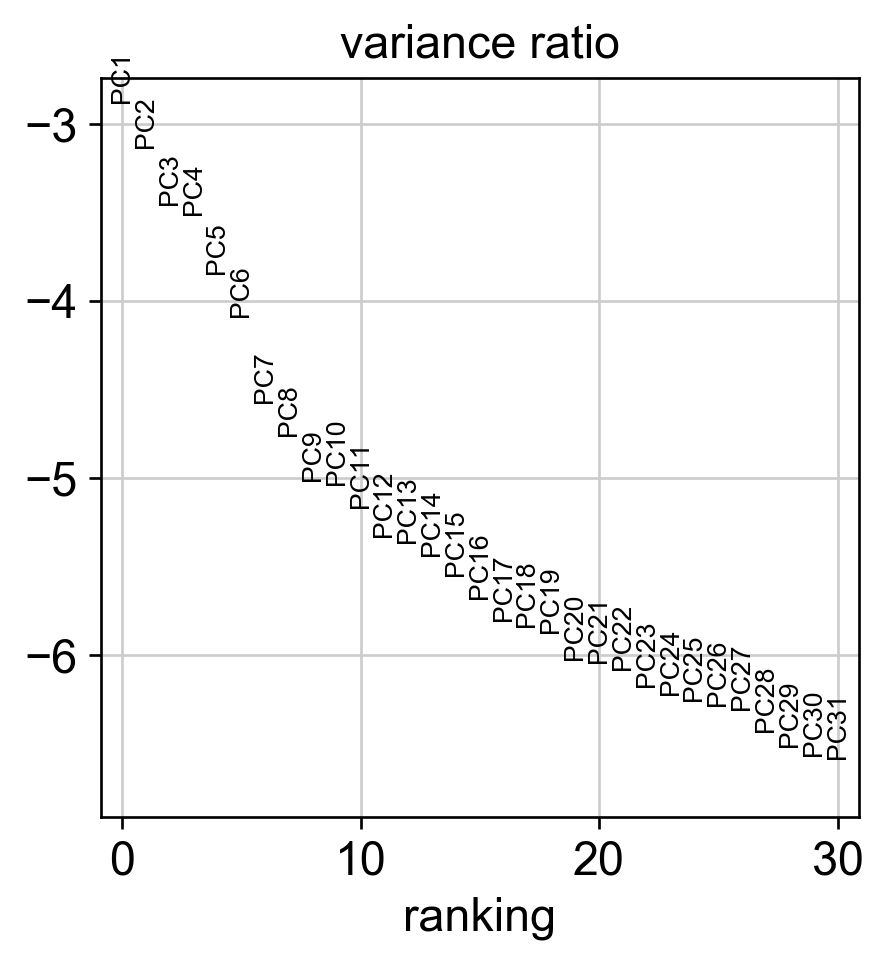

In [43]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [44]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=20) 

In [45]:
# run umap
sc.tl.umap(adata)

# Plot UMAP

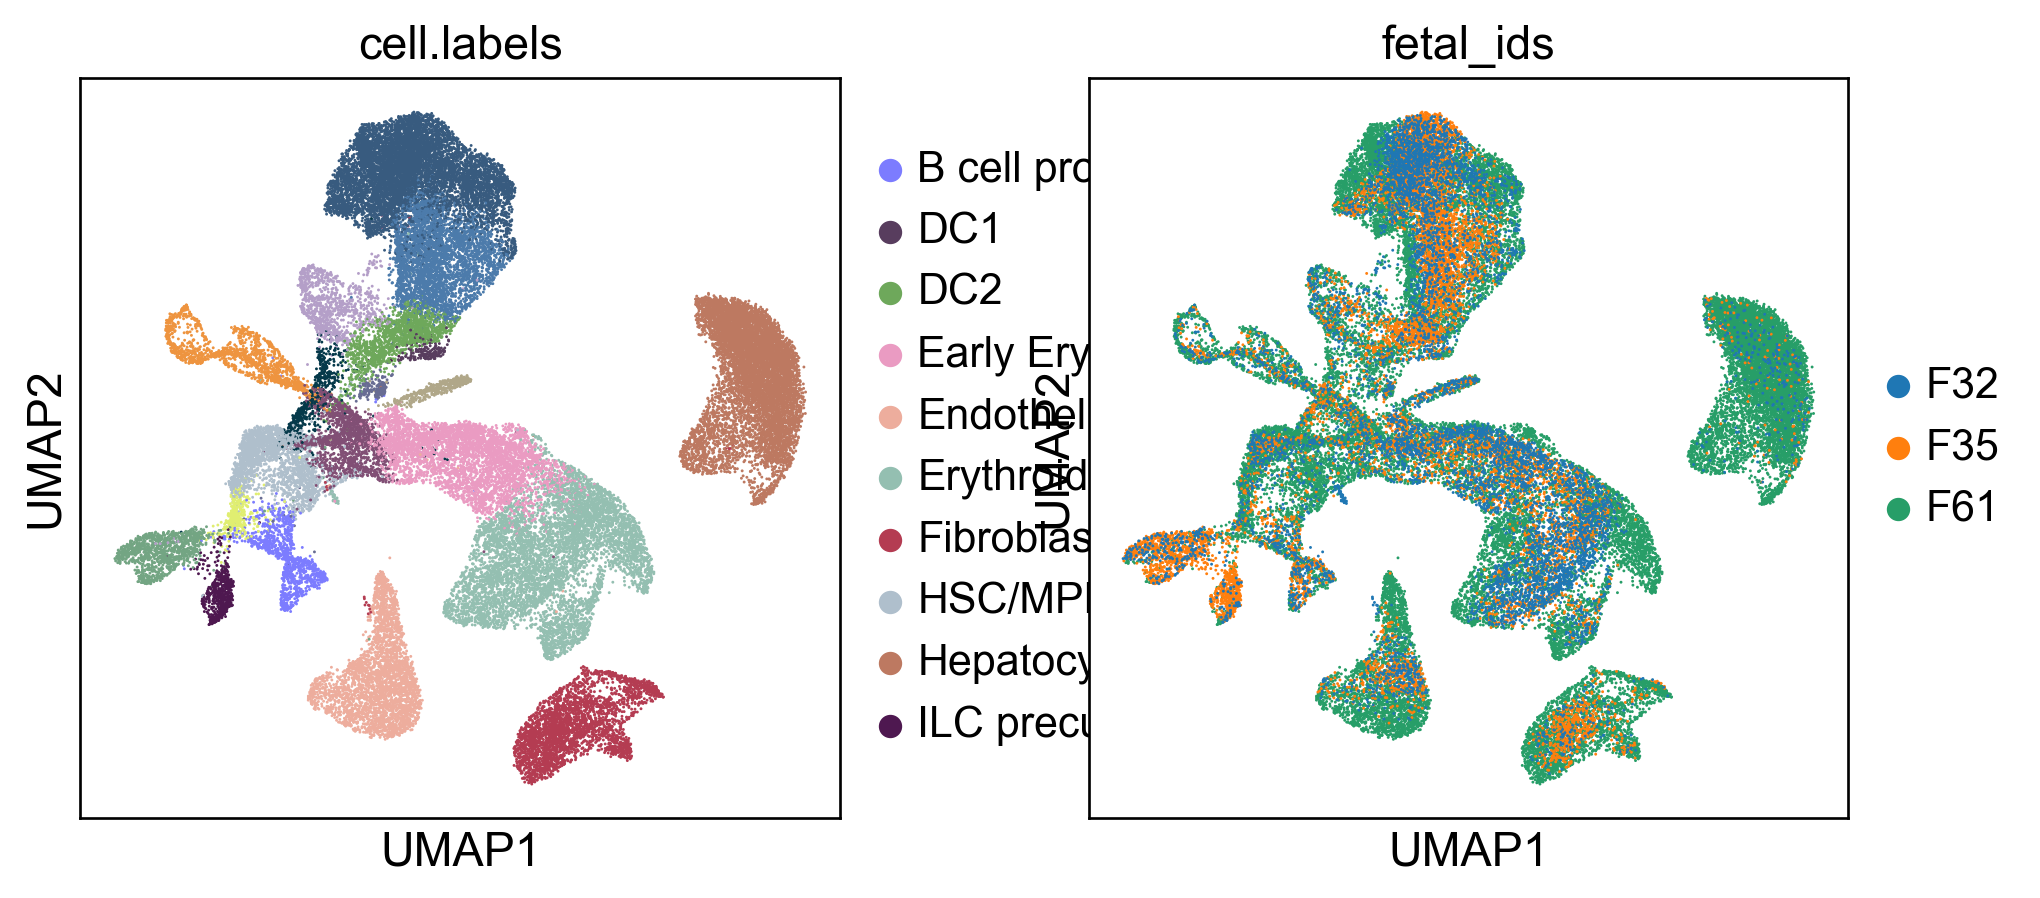

In [46]:
sc.pl.umap(adata, color=['cell.labels', 'fetal_ids'], size=3)

In [47]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_ys_liver_post-harmony_20200430_labels_legoff.pdf', show=False, size=2) 
sc.pl.umap(adata, color='cell.labels', save='_ys_liver_post-harmony_20200430_labels_legon.pdf', show=False, size=2, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='fetal_ids', save='_ys_liver_post-harmony_20200430_sample_legoff.pdf', show=False, size=2) 
sc.pl.umap(adata, color='fetal_ids', save='_ys_liver_post-harmony_20200430_sample_legon.pdf', show=False, size=2, legend_loc="on data", legend_fontsize=6)

# Save the data

In [48]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [49]:
adata.X

<49485x25756 sparse matrix of type '<class 'numpy.float64'>'
	with 115220027 stored elements in Compressed Sparse Row format>

In [50]:
adata.raw.X

<49485x25756 sparse matrix of type '<class 'numpy.float64'>'
	with 127547149 stored elements in Compressed Sparse Row format>

In [51]:
adata.write('/Users/b8058304/Documents/PhD_work/Coding/ys/data/Liver_data_YS_paper_singlets_dr_20200430.h5ad')